# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
from unityagents import UnityEnvironment
import numpy as np
import torch
from torchsummary import summary
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name=os.path.normpath("./Banana_Windows_x86_64/Banana.exe"))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States is of type:', type(state))
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States is of type: <class 'numpy.ndarray'>
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# test the untrained agent for n_test times
n_test = 20
score_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state                             # roll over the state to next time step
        score += reward                                # update the score
        if done:                                       # exit loop if episode finished
            break
    score_list.append(score)

print("Average score (random actions): {}".format(np.mean(score_list)))

Average score (random actions): 0.0


When finished, you can close the environment.
```python
env.close()
```

### 4. Deep Q-learning

#### 4.1. Define the training function and run

A three-layer fully-connected neural network with ReLU activation functions after the first two Linear layers and linear activation function after the last one Linear layer is implemented for deep Q-learning.

The network architecture is shown below (provided by `torchsummary`: https://github.com/sksq96/pytorch-summary):
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                  [-1, 128]           4,864
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 4]             260
================================================================
Total params: 13,380
Trainable params: 13,380
Non-trainable params: 0
```

The learning process employed an Adam optimizer with a learning rate of 5e-4.

In [6]:
def train_dqn(env, agent, save_model, n_episodes=2000,
              eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              finish_threshold=13.0):
    """Deep Q-Learning.
    
    Params
    ======
        env: environment
        agent: deep Q-learning agent
        save_model: model filename for saving
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        finish_threshold (float): the training process will finish if the average score is larger than such threshold
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        step = 0
        while True:
            step += 1
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= finish_threshold:  # save the model
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), save_model)
            break
    return scores

from dqn_agent import Agent

agent_dqn = Agent(state_size, action_size, seed=0, use_double=False)  # deep Q-learning agent
summary(agent_dqn.qnetwork_target, (state_size,))  # print the deep Q-network summary

scores_dqn = train_dqn(env, agent_dqn, 'model_dqn.pt', finish_threshold=14.5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 4]             260
Total params: 13,380
Trainable params: 13,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Episode 100	Average Score: 0.30
Episode 200	Average Score: 1.06
Episode 300	Average Score: 2.24
Episode 400	Average Score: 3.39
Episode 500	Average Score: 6.69
Episode 600	Average Score: 8.87
Episode 700	Average Score: 10.88
Episode 800

#### 4.2. Plot the training score curve

In [7]:
## running mean function
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

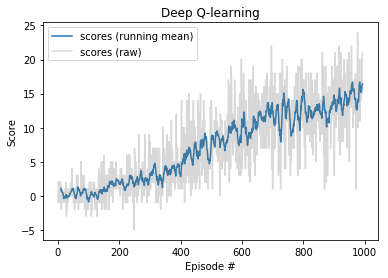

In [8]:
scores_dqn_running_mean = running_mean(scores_dqn, 10)
plt.figure()
plt.plot(np.arange(1, len(scores_dqn)+1)[-len(scores_dqn_running_mean):], scores_dqn_running_mean,
         label='scores (running mean)')
plt.plot(np.arange(1, len(scores_dqn)+1), scores_dqn,
         color='grey', alpha=0.3, label='scores (raw)')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Deep Q-learning')
plt.show()

#### 4.3. Test the trained deep Q-learning agent

In [9]:
# load the weights from the saved checkpoint file
agent_dqn.qnetwork_local.load_state_dict(torch.load('model_dqn.pt'))

# test the trained agent for n_test times
n_test = 20
score_dqn_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent_dqn.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_dqn_list.append(score)

print("Average score (after deep Q-learning): {}".format(np.mean(score_dqn_list)))

Average score (after deep Q-learning): 13.8


### 5. Double deep Q-learning

#### 5.1. Train the agent

In [10]:
agent_doubledqn = Agent(state_size, action_size, seed=0, use_double=True)  # double deep Q-learning agent

scores_doubledqn = train_dqn(env, agent_doubledqn, 'model_doubledqn.pt', finish_threshold=14.5)

Episode 100	Average Score: -0.15
Episode 200	Average Score: 0.661
Episode 300	Average Score: 1.63
Episode 400	Average Score: 4.03
Episode 500	Average Score: 6.66
Episode 600	Average Score: 11.41
Episode 700	Average Score: 12.95
Episode 800	Average Score: 13.99
Episode 900	Average Score: 13.87
Episode 976	Average Score: 14.55
Environment solved in 876 episodes!	Average Score: 14.55


#### 5.2. Plot the training score curve

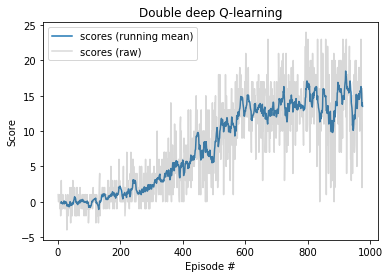

In [11]:
scores_doubledqn_running_mean = running_mean(scores_doubledqn, 10)
plt.figure()
plt.plot(np.arange(1, len(scores_doubledqn)+1)[-len(scores_doubledqn_running_mean):], scores_doubledqn_running_mean,
         label='scores (running mean)')
plt.plot(np.arange(1, len(scores_doubledqn)+1), scores_doubledqn,
         color='grey', alpha=0.3, label='scores (raw)')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Double deep Q-learning')
plt.show()

#### 5.3. Test the trained double deep Q-learning agent

In [12]:
# load the weights from the saved checkpoint file
agent_doubledqn.qnetwork_local.load_state_dict(torch.load('model_doubledqn.pt'))

# test the trained agent for n_test times
n_test = 20
score_doubledqn_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0  # initialize the score
    while True:
        action = agent_doubledqn.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_doubledqn_list.append(score)

print("Average score (after double deep Q-learning): {}".format(np.mean(score_doubledqn_list)))

Average score (after double deep Q-learning): 14.2


### 6. Close the environment

In [13]:
env.close()